In [1]:
## MLFLOW_TRACKING_URI='https://qualiextra-project-6b29e931dd67.herokuapp.com/'

In [3]:
import pandas as pd
import datetime
import numpy as np
from plotly.subplots import make_subplots
from prophet import Prophet
from datetime import datetime

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

In [4]:
data = pd.read_csv("./Missions.csv", sep=';')

In [17]:
data = pd.read_csv("./Missions.csv", sep=";")
mask = data["hôtel"].notna()
data = data[mask]
data["date_debut"] = data.apply(lambda x: x["date"].split(" →")[0], axis=1)
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC+3)", ""))
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC)", ""))
data["date_debut"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y %H:%M")
data["time_delta"] = data["nbre d'heures"].apply(lambda x: pd.to_timedelta(x))
data["date_fin"] = data.apply(lambda x: x["date_debut"] + x["time_delta"], axis=1)
data["Propriété"] = data.apply(
    lambda x: x["hôtel"].split(" (")[0] if "www" in x["Propriété"] else x,
    axis=1,
)["Propriété"]
data["Propriété_clean"] = data["hôtel"].apply(lambda x: x.split(" (")[0])
data["extra_clean"] = data["extra"].apply(lambda x: x.split(" (")[0])
data["periode_debut"] = data["date_debut"].dt.strftime("%m-%Y")
data["periode_fin"] = data["date_fin"].dt.strftime("%m-%Y")
data["Année"] = data["date_fin"].dt.year.astype(str)
data["Mois"] = data["date_fin"].dt.to_period("M").astype(str)
data["Semaine"] = data["date_fin"].dt.to_period("W-Mon").astype(str)
data["marge"] = data.apply(lambda x: x["total HT"] - x["montant HT"], axis=1)
data["mois"] = data["date_fin"].dt.strftime("%B")
data["Jour"] = data["date_fin"].dt.to_period("D").astype(str)
data["statuts"] = data["statuts"].fillna("standard")
data["mois"] = pd.Categorical(
        data["mois"],
        categories=[
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ],
        ordered=True,)

def format_currency(value):
    return f"{value:,} €"

In [18]:
data["Mois2"] = pd.to_datetime(data["date_fin"],format='%m').dt.to_period('M')


In [19]:
aujd = datetime.now()
mois_auj = aujd.strftime("%Y-%m")
mois_précédent = (
    aujd.now()
    .replace(month=aujd.month - 1)
    .strftime("%Y-%m")
)
print(aujd.replace(day=1).strftime("%Y-%m-%d"))

2023-12-01


In [20]:
data_grouby_CA = data.groupby(["mois", "Année"])["total HT"].sum().reset_index()
mask = data_grouby_CA["total HT"] != 0
data_grouby_CA = data_grouby_CA[mask]

fig = px.line(
    data_grouby_CA,
    x="mois",
    y="total HT",
    color="Année",
    text=data_grouby_CA["total HT"].map(format_currency),
    labels={"total HT": "CA", "mois": "Mois"},
    title="Évolution du chiffre d'affaires par mois",
    )

# Mise en forme du graphique
fig.update_traces(textposition="bottom center")
fig.update_xaxes(type="category")
fig.update_yaxes(title_text="CA en k€")

/var/folders/83/w7lxc5zn2gl73gq3cml70sy80000gn/T/ipykernel_49550/2781836616.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouby_CA = data.groupby(["mois", "Année"])["total HT"].sum().reset_index()


In [15]:
premier_jour_du_mois =  aujd.replace(day=1).strftime("%Y-%m-%d")
mask = (data['Jour']<= aujd.strftime("%Y-%m-%d")) & (data['Jour']>= premier_jour_du_mois)
data_month_to_date  = data[mask]

In [16]:
data_month_to_date

,Propriété,hôtel,extra,date,statuts,tarif urgence,tarif horaire,nbre d'heures,total HT,facture,...,extra_clean,periode_debut,periode_fin,Année,Mois,Semaine,marge,mois,Jour,Mois2
108,Milie rose,Milie Rose (https://www.notion.so/Milie-Rose-0...,Mamadou Koma (https://www.notion.so/Mamadou-Ko...,03/12/2023 22:30 → 04/12/2023 8:00,standard,NaN,20.0,9hr 30min,180,NaN,...,Mamadou Koma,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,45,December,2023-12-04,2023-12
109,Ibis Montparnasse,Ibis Montparnasse (https://www.notion.so/Ibis-...,Haissam Baghdadi (https://www.notion.so/Haissa...,03/12/2023 21:30 → 04/12/2023 7:30,standard,NaN,20.0,10hr 0min,200,NaN,...,Haissam Baghdadi,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,50,December,2023-12-04,2023-12
110,Les 2 girafes,Les Deux Girafes (https://www.notion.so/Les-De...,Thomas Guignard (https://www.notion.so/Thomas-...,03/12/2023 20:00 → 04/12/2023 8:00,standard,NaN,20.0,12hr 0min,240,NaN,...,Thomas Guignard,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,60,December,2023-12-04,2023-12
111,Milie rose,Milie Rose (https://www.notion.so/Milie-Rose-0...,Brian Cruman (https://www.notion.so/Brian-Crum...,02/12/2023 22:30 → 03/12/2023 8:00,standard,NaN,20.0,9hr 30min,180,NaN,...,Brian Cruman,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,45,December,2023-12-03,2023-12
112,Ibis Montparnasse,Ibis Montparnasse (https://www.notion.so/Ibis-...,Haissam Baghdadi (https://www.notion.so/Haissa...,02/12/2023 21:30 → 03/12/2023 7:30,standard,NaN,20.0,10hr 0min,200,NaN,...,Haissam Baghdadi,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,50,December,2023-12-03,2023-12
113,Drawing house,Drawing House (https://www.notion.so/Drawing-H...,Mamadou Koma (https://www.notion.so/Mamadou-Ko...,02/12/2023 20:15 → 03/12/2023 7:15,standard,NaN,21.0,11hr 0min,231,NaN,...,Mamadou Koma,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,66,December,2023-12-03,2023-12
114,Imprimerie,Imprimerie (https://www.notion.so/Imprimerie-3...,Eric Da Silva (https://www.notion.so/Eric-Da-S...,02/12/2023 20:00 → 03/12/2023 8:00,standard,NaN,20.0,12hr 0min,240,NaN,...,Eric Da Silva,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,60,December,2023-12-03,2023-12
115,Les 2 girafes,Les Deux Girafes (https://www.notion.so/Les-De...,Thomas Guignard (https://www.notion.so/Thomas-...,02/12/2023 20:00 → 03/12/2023 8:00,standard,NaN,20.0,12hr 0min,240,NaN,...,Thomas Guignard,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,60,December,2023-12-03,2023-12
116,Ibis Montparnasse,Ibis Montparnasse (https://www.notion.so/Ibis-...,Alain Itoua (https://www.notion.so/Alain-Itoua...,02/12/2023 15:00 → 21:00,standard,NaN,20.0,6hr 0min,120,NaN,...,Alain Itoua,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,30,December,2023-12-02,2023-12
117,Ibis Montparnasse,Ibis Montparnasse (https://www.notion.so/Ibis-...,Sidi Fofana (https://www.notion.so/Sidi-Fofana...,02/12/2023 7:00 → 14:00,standard,NaN,20.0,7hr 0min,140,NaN,...,Sidi Fofana,12-2023,12-2023,2023,2023-12,2023-11-28/2023-12-04,35,December,2023-12-02,2023-12


In [10]:
data["Jour"][0]

'2024-01-07'

In [5]:
data.head()

,Propriété,hôtel,extra,date,statuts,tarif urgence,tarif horaire,nbre d'heures,total HT,facture,...,Propriété_clean,extra_clean,periode_debut,periode_fin,Année,Mois,Semaine,marge,mois,Jour
0,Crystal,Crystal (https://www.notion.so/Crystal-1837fcb...,Grégory Tshimini (https://www.notion.so/Gr-gor...,07/01/2024 8:00 → 20:00,standard,NaN,21.0,12hr 0min,252,NaN,...,Crystal,Grégory Tshimini,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,72,January,2024-01-07
1,Milie rose,Milie Rose (https://www.notion.so/Milie-Rose-0...,Mamadou Koma (https://www.notion.so/Mamadou-Ko...,06/01/2024 22:30 → 07/01/2024 8:00,standard,NaN,20.0,9hr 30min,180,NaN,...,Milie Rose,Mamadou Koma,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,45,January,2024-01-07
2,Touraine,Touraine (https://www.notion.so/Touraine-df4e7...,Mohamed Belbachir (https://www.notion.so/Moham...,06/01/2024 19:30 → 07/01/2024 7:30,standard,NaN,20.0,12hr 0min,240,NaN,...,Touraine,Mohamed Belbachir,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,60,January,2024-01-07
3,Crystal,Crystal (https://www.notion.so/Crystal-1837fcb...,Grégory Tshimini (https://www.notion.so/Gr-gor...,06/01/2024 8:00 → 20:00,standard,NaN,21.0,12hr 0min,252,NaN,...,Crystal,Grégory Tshimini,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,72,January,2024-01-06
4,Milie rose,Milie Rose (https://www.notion.so/Milie-Rose-0...,Mamadou Koma (https://www.notion.so/Mamadou-Ko...,05/01/2024 22:30 → 06/01/2024 8:00,standard,NaN,20.0,9hr 30min,180,NaN,...,Milie Rose,Mamadou Koma,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,45,January,2024-01-06


In [15]:
type(data["mois"][0])

str

In [32]:
data2 = data.groupby(["mois", "Année"])["extra_clean"].nunique().reset_index()

In [33]:
data2.head()

,mois,Année,extra_clean
0,01,2022,10
1,01,2023,28
2,01,2024,7
3,02,2022,13
4,02,2023,29


In [10]:
data["Mois_WY"][0]

Period('2024-01', 'M')

In [8]:
data_ts = data.groupby("date")[["extra"]].count()
data_ts.head()

,extra
date,
2021-11-30,1
2021-12-01,1
2021-12-02,1
2021-12-03,4
2021-12-04,3


In [9]:
fig = px.line(data_ts)
fig.show()

In [10]:
split_date = datetime.strptime('2023-10-31', "%Y-%m-%d").date()
data_train = data_ts.loc[data_ts.index <= split_date].copy()
data_test = data_ts.loc[data_ts.index > split_date].copy()

In [11]:
fig = px.line(data_train)
fig.add_trace(px.line(data_test).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

In [12]:
data_train = pd.DataFrame({
    "ds":data_train.index,
    "y": data_train["extra"]
}).reset_index(drop=True)
data_train.head()

,ds,y
0,2021-11-30,1
1,2021-12-01,1
2,2021-12-02,1
3,2021-12-03,4
4,2021-12-04,3


In [13]:
m = Prophet()
m.fit(data_train)

11:01:00 - cmdstanpy - INFO - Chain [1] start processing
11:01:00 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
data_test = pd.DataFrame({
    "ds":data_test.index,
    "y": data_test["extra"]
}).reset_index(drop=True)
data_test.head()

,ds,y
0,2023-11-01,6
1,2023-11-02,7
2,2023-11-03,12
3,2023-11-04,12
4,2023-11-05,10


In [ ]:
forecast = m.predict(data_test)
fig = px.line(data_test, x = "ds", y = "y")
fig.add_trace(px.line(forecast, x = "ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

/Users/simoncld/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
mse = mean_squared_error(y_true=data_test['y'],
                   y_pred=forecast['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

mae = mean_absolute_error(y_true=data_test['y'],
                   y_pred=forecast['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=data_test['y'],
                   y_pred=forecast['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MSE on the test set is : 
 34.67289531994379
The MAE on the test set is : 
 5.28319496732711
The MAPE on the test set is : 
 236.99587013539568


In [ ]:
data_holiday1=pd.read_csv("data.csv")
frequentation=pd.read_csv("frequentation.csv", delimiter=";")
data_holiday1.head()

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances
0,1990-01-01,False,False,False,NaN
1,1990-01-02,False,False,False,NaN
2,1990-01-03,False,False,False,NaN
3,1990-01-04,False,False,False,NaN
4,1990-01-05,False,False,False,NaN


In [ ]:
data_holiday1["date"]=data_holiday1["date"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d").date())
data_holiday1 = data_holiday1.drop(columns=['vacances_zone_a','vacances_zone_b','vacances_zone_c'])
mask = data_holiday1["nom_vacances"].notna()
data_holiday = data_holiday1[mask]
data_holiday["ds"] = data_holiday["date"]
data_holiday["holiday"]=data_holiday["nom_vacances"]
data_holiday.head()

/var/folders/83/w7lxc5zn2gl73gq3cml70sy80000gn/T/ipykernel_42129/2363096038.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/83/w7lxc5zn2gl73gq3cml70sy80000gn/T/ipykernel_42129/2363096038.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,nom_vacances,ds,holiday
299,1990-10-27,Vacances de la Toussaint,1990-10-27,Vacances de la Toussaint
300,1990-10-28,Vacances de la Toussaint,1990-10-28,Vacances de la Toussaint
301,1990-10-29,Vacances de la Toussaint,1990-10-29,Vacances de la Toussaint
302,1990-10-30,Vacances de la Toussaint,1990-10-30,Vacances de la Toussaint
303,1990-10-31,Vacances de la Toussaint,1990-10-31,Vacances de la Toussaint


In [ ]:
split_date = datetime.strptime('2023-10-31', "%Y-%m-%d").date()
data_train = data_ts.loc[data_ts.index <= split_date].copy()
data_test = data_ts.loc[data_ts.index > split_date].copy()

data_train = pd.DataFrame({
    "ds":data_train.index,
    "y": data_train["extra"]
}).reset_index(drop=True)
data_train.head()


m = Prophet(holidays=data_holiday)
m.fit(data_train)

data_test = pd.DataFrame({
    "ds":data_test.index,
    "y": data_test["extra"]
}).reset_index(drop=True)
data_test.head()

forecast = m.predict(data_test)

fig = px.line(data_test, x = "ds", y = "y")
fig.add_trace(px.line(forecast, x = "ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

/Users/simoncld/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

09:39:23 - cmdstanpy - INFO - Chain [1] start processing
09:39:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/simoncld/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
data_merge = pd.merge(data_holiday1, data_ts, on='date', how='inner')

In [ ]:
data_merge.head()

,date,nom_vacances,extra
0,2021-11-30,NaN,1
1,2021-12-01,NaN,1
2,2021-12-02,NaN,1
3,2021-12-03,NaN,4
4,2021-12-04,NaN,3


In [ ]:
data_merge['nom_vacances'] = data_merge['nom_vacances'].fillna(0)
data_merge['nom_vacances'] = data_merge['nom_vacances'].apply(lambda x: 1 if x != 0 else 0)
data_merge["nom_vacances"].value_counts()

nom_vacances
0    449
1    317
Name: count, dtype: int64

In [ ]:
frequentation.head()

,Libellé,Taux d'occupation dans l'hôtellerie - France,Codes
0,idBank,010599344,NaN
1,Dernière mise à jour,09/11/2023 14:18,NaN
2,Période,NaN,NaN
3,2023-12,NaN,NaN
4,2023-11,NaN,NaN


In [ ]:
frequentation = frequentation.loc[6:,:]
frequentation["date"]=frequentation["Libellé"].apply(lambda x : pd.to_datetime(x))
frequentation = frequentation.drop(columns=["Codes","Libellé"])

In [ ]:
frequentation.set_index('date', inplace=True)
frequentation_resampled = frequentation .resample('D').ffill()
frequentation_resampled.reset_index(inplace=True)
frequentation_resampled.head()

,date,Taux d'occupation dans l'hôtellerie - France
0,2021-01-01,31.9
1,2021-01-02,31.9
2,2021-01-03,31.9
3,2021-01-04,31.9
4,2021-01-05,31.9


In [ ]:
frequentation_resampled['date'] = pd.to_datetime(frequentation_resampled['date'])
data_merge['date'] = pd.to_datetime(data_merge['date'])
data_merge = pd.merge(frequentation_resampled, data_merge, on='date', how='inner')

In [ ]:
data_merge.head()

,date,Taux d'occupation dans l'hôtellerie - France,nom_vacances,extra
0,2021-11-30,52.9,0,1
1,2021-12-01,46.8,0,1
2,2021-12-02,46.8,0,1
3,2021-12-03,46.8,0,4
4,2021-12-04,46.8,0,3


In [ ]:
# Normalisation des données
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data_merge[['Taux d\'occupation dans l\'hôtellerie - France', 'nom_vacances', 'extra']])

# Préparation des données pour le modèle LSTM
X, y = [], []
for i in range(len(data_scaled)-60):
    X.append(data_scaled[i:i+60])
    y.append(data_scaled[i+60, 2])  # 'extra' est la troisième colonne

X, y = np.array(X), np.array(y)

# Division des données
X_train, y_train = X[:-60], y[:-60]
X_test, y_test = X[-60:], y[-60:]

# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(60, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
model.fit(X_train, y_train, epochs=500, batch_size=8, verbose=1)

# Prédictions sur l'ensemble de test
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], predictions_scaled)))

# Évaluation du modèle
mse = mean_squared_error(data_merge[-60:]['extra'], predictions[:, 2])
print(f'Mean Squared Error: {mse}')



Epoch 1/500
65/65 [==============================] - 1s 8ms/step - loss: 0.5700
Epoch 2/500
65/65 [==============================] - 0s 7ms/step - loss: 0.4907
Epoch 3/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4749
Epoch 4/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4688
Epoch 5/500
65/65 [==============================] - 0s 8ms/step - loss: 0.4584
Epoch 6/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4606
Epoch 7/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4475
Epoch 8/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4503
Epoch 9/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4563
Epoch 10/500
65/65 [==============================] - 0s 8ms/step - loss: 0.4440
Epoch 11/500
65/65 [==============================] - 1s 8ms/step - loss: 0.4341
Epoch 12/500
65/65 [==============================] - 0s 8ms/step - loss: 0.4313
Epoch 13/500
65/65 [=================

In [ ]:
fig = px.line()
fig.add_trace(px.line(data_merge, x = data_merge["date"][-60:], y=data_merge[-60:]['extra']).data[0])
fig.add_trace(px.line(data_merge, x = data_merge["date"][-60:], y=predictions[:, 2]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig['data'][2]['line']['color']="red"
fig.show()

/Users/simoncld/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/simoncld/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/Users/simoncld/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/simoncld/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/simoncld/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/simoncld/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/simoncld/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWa

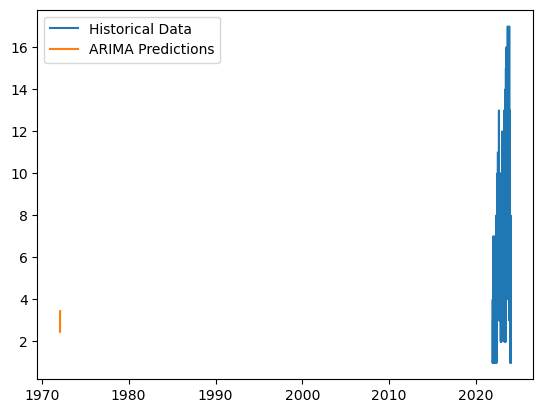

In [14]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Préparation des données pour ARIMA
df_arima = data_ts

# Recherche automatique des paramètres ARIMA
model_arima = auto_arima(df_arima['extra'], seasonal=True, m=7)

# Création du modèle ARIMA avec les meilleurs paramètres
model_arima = ARIMA(df_arima['extra'], order=model_arima.order)
model_arima_fit = model_arima.fit()

# Prédictions
predictions_arima = model_arima_fit.predict(start=len(df_arima), end=len(df_arima)+6, typ='levels')

# Visualisation des prédictions
plt.plot(df_arima.index, df_arima['extra'], label='Historical Data')
plt.plot(predictions_arima.index, predictions_arima, label='ARIMA Predictions')
plt.legend()
plt.show()